# This model works with predicitng the classification

1. 2D CNN (Custom) – EEG data
2. EfficientNet – Spectrogram data
3. XGBoost – Spectrogram data
4. Random Forest – EEG data

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/eeg_spect_full_features.csv")

In [3]:
from sklearn.preprocessing import LabelEncoder

eeg_cols = [
    'Fp1_median', 'Fp1_std', 'Fp1_min', 'Fp1_max',
    'O1_median', 'O1_std', 'O1_min', 'O1_max',
    'O2_median', 'O2_std', 'O2_min', 'O2_max',
    'Fp2_median', 'Fp2_std', 'Fp2_min', 'Fp2_max'
]

spec_cols = [
    'LL_median', 'LL_std', 'LL_min', 'LL_max',
    'RL_median', 'RL_std', 'RL_min', 'RL_max',
    'LP_median', 'LP_std', 'LP_min', 'LP_max',
    'RP_median', 'RP_std', 'RP_min', 'RP_max'
]

# --- Features and target ---
X_eeg = df[eeg_cols].values
X_spect = df[spec_cols].values
y_raw = df['expert_consensus'].values

# --- Encode target labels (str -> int) ---
le = LabelEncoder()
y = le.fit_transform(y_raw)

In [5]:
# --- Train/Test Split ---
from sklearn.model_selection import train_test_split
X_eeg_train, X_eeg_test, X_spect_train, X_spect_test, y_train, y_test = train_test_split(
    X_eeg, X_spect, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Normalize EEG and Spectrogram data
scaler_eeg = StandardScaler()
X_eeg_train_scaled = scaler_eeg.fit_transform(X_eeg_train)
X_eeg_test_scaled = scaler_eeg.transform(X_eeg_test)

In [7]:
scaler_spec = StandardScaler()
X_spect_train_scaled = scaler_spec.fit_transform(X_spect_train)
X_spect_test_scaled = scaler_spec.transform(X_spect_test)

In [11]:
# --- Spectrogram CNN Model (Keras EfficientNet-style) ---
X_spect_train_img = X_spect_train_scaled.reshape(-1, 4, 4, 1)
X_spect_test_img = X_spect_test_scaled.reshape(-1, 4, 4, 1)

In [12]:
from tensorflow.keras.utils import to_categorical

# OPTIONAL: If you prefer to use 'mse', convert y_train to one-hot:
# y_train_cat = to_categorical(y_train, num_classes=6)

input_img = Input(shape=(4, 4, 1))
x = GlobalAveragePooling2D()(input_img)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)  # Changed from 'linear'

eff_model = Model(input_img, output)
eff_model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Changed loss

# Train the model
eff_model.fit(
    X_spect_train_img, y_train,  # y_train is fine as int labels now
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.1929 - loss: 1.7826 - val_accuracy: 0.1967 - val_loss: 1.7781
Epoch 2/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.2008 - loss: 1.7782 - val_accuracy: 0.1972 - val_loss: 1.7763
Epoch 3/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - accuracy: 0.1990 - loss: 1.7763 - val_accuracy: 0.1982 - val_loss: 1.7753
Epoch 4/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - accuracy: 0.2005 - loss: 1.7768 - val_accuracy: 0.1973 - val_loss: 1.7760
Epoch 5/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - accuracy: 0.1993 - loss: 1.7763 - val_accuracy: 0.1929 - val_loss: 1.7745
Epoch 6/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.1970 - loss: 1.7754 - val_accuracy: 0.1980 - val_loss: 1.7741
Epoch 7/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.1976 - loss: 1.7752 - val_accuracy: 0.1972 - val_loss: 1.7743
Epoch 8/100
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - accuracy: 

In [ ]:
# EfficientNet-style predictions
eff_preds_train = np.vstack([
    eff_model.predict(np.expand_dims(X_spect_train_img[i], axis=0))
    for i in tqdm(range(len(X_spect_train_img)), desc="EffNet Train Predict")
])
eff_preds_test = np.vstack([
    eff_model.predict(np.expand_dims(X_spect_test_img[i], axis=0))
    for i in tqdm(range(len(X_spect_test_img)), desc="EffNet Test Predict")
])

In [14]:
# --- EEG CNN (PyTorch) ---
class EEG_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 2, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 2, stride=1, padding=1)
        dummy = torch.zeros(1, 1, 4, 4)
        out = self._forward_conv(dummy)
        self.fc1 = nn.Linear(out.view(1, -1).size(1), 128)
        self.out = nn.Linear(128, 6)

    def _forward_conv(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)


In [15]:
# Prepare tensors
X_eeg_train_tensor = torch.tensor(X_eeg_train_scaled, dtype=torch.float32).view(-1, 1, 4, 4)
X_eeg_test_tensor = torch.tensor(X_eeg_test_scaled, dtype=torch.float32).view(-1, 1, 4, 4)

cnn_model = EEG_CNN()
cnn_model.eval()

# CNN Predictions with tqdm
cnn_preds_train = []
cnn_preds_test = []


In [16]:
with torch.no_grad():
    for i in tqdm(range(len(X_eeg_train_tensor)), desc="CNN Train Prediction"):
        out = cnn_model(X_eeg_train_tensor[i].unsqueeze(0))
        cnn_preds_train.append(out.numpy())
    for i in tqdm(range(len(X_eeg_test_tensor)), desc="CNN Test Prediction"):
        out = cnn_model(X_eeg_test_tensor[i].unsqueeze(0))
        cnn_preds_test.append(out.numpy())

cnn_preds_train = np.vstack(cnn_preds_train)
cnn_preds_test = np.vstack(cnn_preds_test)


CNN Test Prediction: 100%|██████████| 21360/21360 [00:01<00:00, 14886.12it/s]


In [17]:
# --- XGBoost on Spectrogram Data ---
xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_class=6, eval_metric="mlogloss", use_label_encoder=False)
xgb_model.fit(X_spect_train_scaled, y_train)
xgb_preds_train = xgb_model.predict_proba(X_spect_train_scaled)
xgb_preds_test = xgb_model.predict_proba(X_spect_test_scaled)


/Users/Patron/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
# --- Random Forest on EEG Data ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_eeg_train_scaled, y_train)
rf_preds_train = rf_model.predict_proba(X_eeg_train_scaled)
rf_preds_test = rf_model.predict_proba(X_eeg_test_scaled)


In [19]:
# --- Final Ensemble ---
X_train_ensemble = np.concatenate([cnn_preds_train, eff_preds_train, xgb_preds_train, rf_preds_train], axis=1)
X_test_ensemble = np.concatenate([cnn_preds_test, eff_preds_test, xgb_preds_test, rf_preds_test], axis=1)


In [20]:
ensemble_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
ensemble_model.fit(X_train_ensemble, y_train)
y_pred = ensemble_model.predict(X_test_ensemble)


/Users/Patron/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [21]:
acc = accuracy_score(y_test, y_pred)
print("✅ Ensemble Accuracy:", acc)

✅ Ensemble Accuracy: 0.9401217228464419



📊 Classification Report:

              precision    recall  f1-score   support

         GPD       0.97      0.96      0.97      3340
        GRDA       0.98      0.97      0.98      3772
         LPD       0.91      0.90      0.90      2971
        LRDA       0.95      0.96      0.95      3328
       Other       0.89      0.92      0.91      3762
     Seizure       0.93      0.93      0.93      4187

    accuracy                           0.94     21360
   macro avg       0.94      0.94      0.94     21360
weighted avg       0.94      0.94      0.94     21360



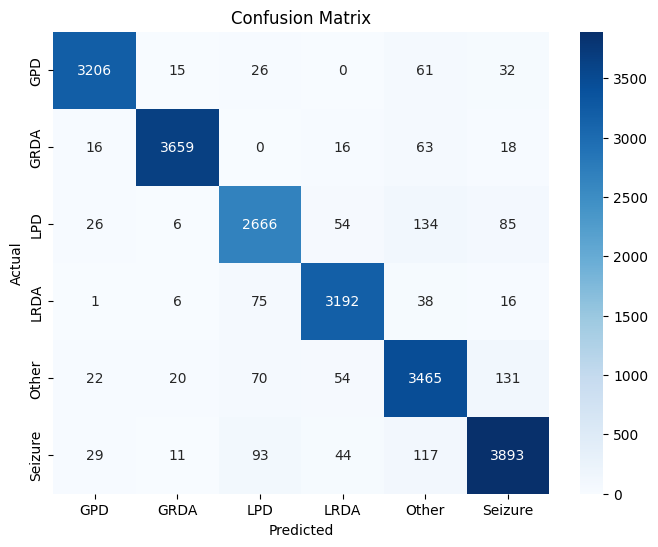

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict with the final ensemble model
y_pred = ensemble_model.predict(X_test_ensemble)

# Print Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()